## Imports

importing the necessary modules for image processing along with dataset processing as in converting xml format to txt format, and getting dataset into structure which is well suited for pipeline

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

In [85]:
import os
import xml.etree.ElementTree as ET

"""
dirs: Folders for processed dataset, split into train, test and validation
"""

dirs = ["dataset/train", "dataset/test", "dataset/val"]

dataset_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/PCB_DATASET')
for dir in dirs:
  dir_path = os.path.join(dataset_dir, dir)
  os.makedirs(dir_path, exist_ok=True)

In [86]:
#These are the classes which can be seen from PCB Dataset
class_names = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

## YOLO Version 10

The below 5 cells are being used to setup YOLO10, along with downloading pre-trained networks which would be used to fine-tune.

In [1]:
!git clone https://github.com/THU-MIG/yolov10

Cloning into 'yolov10'...
remote: Enumerating objects: 20329, done.
remote: Counting objects: 100% (2443/2443), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 20329 (delta 2315), reused 2196 (delta 2196), pack-reused 17886 (from 1)
Receiving objects: 100% (20329/20329), 11.14 MiB | 19.11 MiB/s, done.
Resolving deltas: 100% (14335/14335), done.


In [2]:
%cd yolov10

/content/yolov10


In [3]:
!pip install . --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import os
import urllib.request

weights_dir = os.path.join(os.getcwd(), 'weights')
os.makedirs(weights_dir, exist_ok=True)

urls = [
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10s.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10m.pt"
]

for url in urls:
  filename = os.path.join(weights_dir, os.path.basename(url))
  urllib.request.urlretrieve(url, filename)
  print(f"Downloaded: {filename}")

Downloaded: /content/yolov10/weights/yolov10n.pt
Downloaded: /content/yolov10/weights/yolov10s.pt
Downloaded: /content/yolov10/weights/yolov10m.pt


In [10]:
!yolo task=detect mode=predict conf=0.25 save=True model=/content/yolov10/weights/yolov10n.pt source=test_images/horse.jpeg

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
Ultralytics YO

## Exploration and Dataset Prepration

In this section, we would be taking the data from PCB_DATASET, classify them into different folders in order to make dataset structure compatible for later training using a configured pipeline.

Originally data is in XML format, we want to convert the data into TXT format in order to use it with this specific YOLO pipelines. Also the txt files contain `<class_id> <x_center> <y_center> <width> <height>
` meanwhile the xml files contain `x_min x_max y_min y_max` values. These are being processed using a simple formula involving `width` and `height`, this would be mentioned later on.

In [87]:
root_dir = '/content/drive/MyDrive'

dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

/content/drive/MyDrive/PCB_DATASET/rotation
/content/drive/MyDrive/PCB_DATASET/Annotations
/content/drive/MyDrive/PCB_DATASET/images
/content/drive/MyDrive/PCB_DATASET/PCB_USED
/content/drive/MyDrive/PCB_DATASET/images_resized
/content/drive/MyDrive/PCB_DATASET/output
/content/drive/MyDrive/PCB_DATASET/train9
/content/drive/MyDrive/PCB_DATASET/.ipynb_checkpoints
/content/drive/MyDrive/PCB_DATASET/dataset
/content/drive/MyDrive/PCB_DATASET/rotation/Open_circuit_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Missing_hole_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Spurious_copper_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Mouse_bite_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Short_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Spur_rotation
/content/drive/MyDrive/PCB_DATASET/Annotations/Missing_hole
/content/drive/MyDrive/PCB_DATASET/Annotations/Open_circuit
/content/drive/MyDrive/PCB_DATASET/Annotations/Short
/content/drive/MyDrive/PCB_DATASET/An

In [88]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [90]:
"""
This section explores the dataset a little bit, checking each class and its count. The classes will be found to be
very well balanced which is ideal case in a machine learning scenario with a few contraints.
"""

subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


In [92]:
"""
The XML format itself is flawless, but the method I am using requires a specific
structure of folder for the data to be read into the machine learning pipeline.

Currently we have PCB_DATASET/Annotations/<CLASS_NAME>/ we need to convert that
into dataset/train/images and dataset/train/labels, and the lables need to be in
a txt format with <class_id> <x_center> <y_center> <width> <height>

Original XML format:
<annotation>
	<folder>Missing_hole</folder>
	<filename>01_missing_hole_05.jpg</filename>
	<path>/home/weapon/Desktop/PCB_DATASET/Missing_hole/01_missing_hole_05.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>3034</width>
		<height>1586</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>missing_hole</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>804</xmin>
			<ymin>298</ymin>
			<xmax>860</xmax>
			<ymax>365</ymax>
		</bndbox>
	</object>
</annotation>

Converted txt format:
0 0.5421875 0.26953125 0.015625 0.0328125
"""
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })
    return data

In [96]:
"""
from the all_data, we can see that we have extracted each of XML content in a
key-value format which is not kept in a python based script
"""

all_data = []

for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))
all_data[0]

{'filename': '01_missing_hole_01.jpg',
 'width': 3034,
 'height': 1586,
 'class': 'missing_hole',
 'xmin': 2459,
 'ymin': 1274,
 'xmax': 2530,
 'ymax': 1329}

In [97]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_missing_hole_01.jpg,3034,1586,missing_hole,2459,1274,2530,1329
1,01_missing_hole_01.jpg,3034,1586,missing_hole,1613,334,1679,396
2,01_missing_hole_01.jpg,3034,1586,missing_hole,1726,794,1797,854
3,01_missing_hole_02.jpg,3034,1586,missing_hole,2584,232,2650,298
4,01_missing_hole_02.jpg,3034,1586,missing_hole,2366,803,2406,860


## Visualization

The below code cells are just for dataset exploration, meaning that we are just going to be seeing the annotated images with original labels

In [99]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [100]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

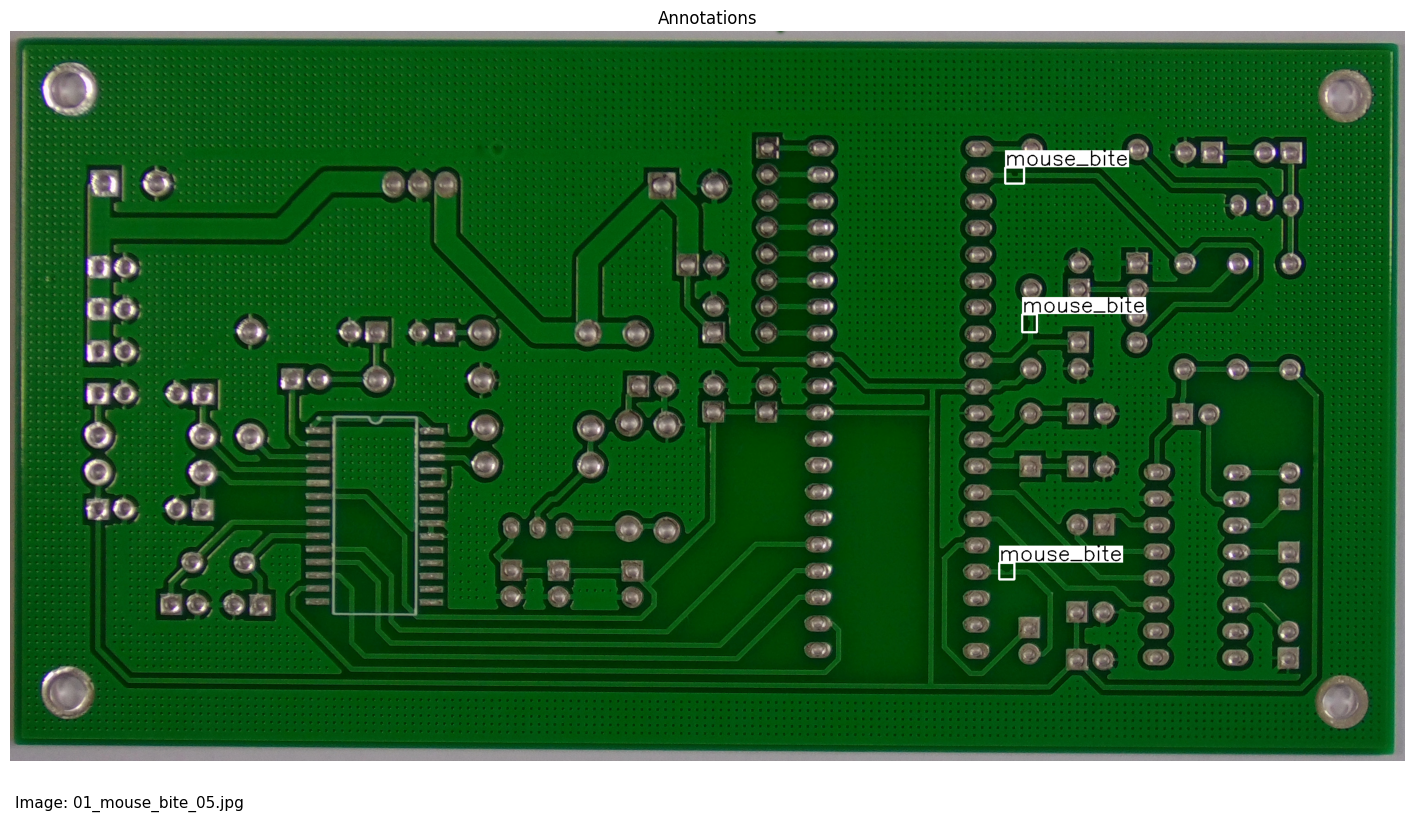

In [102]:
image_name = '01_mouse_bite_05.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True)

##Resizing Images AND Annotations

Originally the images are quite high in resolution, which will eventually slow the learning process, we are going to be resizing the images to `640x640`.

In [105]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = '/content/drive/MyDrive/PCB_DATASET/images_resized'
resize_images(images_dir, resized_img_dir)

In [106]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_missing_hole_01.jpg,640,640,missing_hole,518,514,533,536
1,01_missing_hole_01.jpg,640,640,missing_hole,340,134,354,159
2,01_missing_hole_01.jpg,640,640,missing_hole,364,320,379,344
3,01_missing_hole_02.jpg,640,640,missing_hole,545,93,558,120
4,01_missing_hole_02.jpg,640,640,missing_hole,499,324,507,347


##Putting Data Together



In [108]:
# Create the output directory
output_dir = '/content/drive/MyDrive/PCB_DATASET/dataset'

os.makedirs(output_dir, exist_ok=True)

In [111]:
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)

print(len(yolo_labels))
print(yolo_labels[0])

2953
('01_missing_hole_01.jpg', 0, 0.82109375, 0.8203125, 0.0234375, 0.034375)


In [116]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.75, val_split=0.15):
    # Create the required directories
    os.makedirs(os.path.join(output_dir, 'train/images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'train/labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val/images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val/labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test/images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test/labels'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Function to copy files and write labels
    def copy_files_and_labels(filenames, dataset):
        for filename in filenames:
            # Write labels to the corresponding label files
            with open(os.path.join(output_dir, f'{dataset}/labels/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in image_labels[filename]:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")

            # Copy the image to the corresponding image folder
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'{dataset}/images/{filename}'))

    # Process train, val, and test datasets
    copy_files_and_labels(train_filenames, 'train')
    copy_files_and_labels(val_filenames, 'val')
    copy_files_and_labels(test_filenames, 'test')


split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

## Training and Testing

In [72]:
!yolo task=detect mode=train epochs=10 batch=16 plots=True model=/content/yolov10/weights/yolov10n.pt data=/content/custom_data.yaml

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
New https://py

In [76]:
!yolo task=detect mode=predict conf=0.25 save=True model=/content/runs/detect/train9/weights/best.pt source=/content/drive/MyDrive/PCB_DATASET/output/test/images/06_short_11.jpg

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
Ultralytics YO

In [78]:
!cp -r /content/runs/detect/train9 /content/drive/MyDrive/PCB_DATASET/